# Artist Style Fusion Pipeline Demo

This notebook demonstrates the full pipeline for fine-tuning Stable Diffusion with LoRA to adapt to artists' styles, merging styles, generating images, and evaluating results using CLIP. The pipeline uses the modularized code from the `IE7374-Group6` repository.

## Prerequisites
- Ensure images are in `data/processed/` with filenames like `Pablo_Picasso_001.jpg`.
- Update `configs/model_config.yaml` with desired adapter paths and weights.
- Install dependencies: `pip install -r requirements.txt`.
- Run this notebook in an environment with GPU support (CUDA or MPS) for faster processing.

## Pipeline Steps
1. Load and preprocess the dataset.
2. Train LoRA adapters for artists (optional if weights exist).
3. Merge LoRA adapters for style fusion.
4. Generate 5–10 images with fused styles.
5. Evaluate images using CLIP scores.

Outputs are saved to `outputs/lora_weights/` (LoRA weights) and `outputs/images/` (generated images).

## Step 1: Setup and Imports
Set up the environment, import necessary modules, and configure logging.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add parent directory to path for imports

import logging
import yaml
from src.data_loader import load_artist_dataset
from src.train import train_lora_for_artist, run_all_lora_training
from src.model_runner import load_fused_lora_pipeline, generate_images, evaluate_pipeline
from utils.helper import setup_device, load_pipeline
from PIL import Image
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set device
device = setup_device()
logger.info(f'Starting demo pipeline on {device}')

/Users/rays/Library/CloudStorage/OneDrive-NortheasternUniversity/IE7374 - Generative AI/IE7374-Group6/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-27 20:23:36,643 - utils.helper - INFO - Using device: mps
2025-07-27 20:23:36,644 - __main__ - INFO - Starting demo pipeline on mps


## Step 2: Load Configuration
Load hyperparameters and model settings from `configs/model_config.yaml`.

In [2]:
project_root = os.path.abspath('..')
with open(os.path.join(project_root, 'configs/model_config.yaml'), 'r') as f:
    config = yaml.safe_load(f)

base_model = config['model']['base_model']
adapter_paths = [os.path.join(project_root, p) for p in config['fusion']['adapter_paths']]
weights = config['fusion']['weights']
fusion_name = '+'.join([os.path.basename(p) for p in adapter_paths])
output_dir = os.path.join(project_root, 'outputs/images/fusion_outputs', fusion_name)

logger.info(f'Using base model: {base_model}')
logger.info(f'Adapter paths: {adapter_paths}')
logger.info(f'Weights: {weights}')

2025-07-27 20:23:40,654 - __main__ - INFO - Using base model: stabilityai/sd-turbo
2025-07-27 20:23:40,655 - __main__ - INFO - Adapter paths: ['/Users/rays/Library/CloudStorage/OneDrive-NortheasternUniversity/IE7374 - Generative AI/IE7374-Group6/outputs/lora_weights/Pablo_Picasso', '/Users/rays/Library/CloudStorage/OneDrive-NortheasternUniversity/IE7374 - Generative AI/IE7374-Group6/outputs/lora_weights/Vincent_van_Gogh']
2025-07-27 20:23:40,656 - __main__ - INFO - Weights: [0.5, 0.5]


## Step 3: Load Dataset
Load the artist dataset from `data/processed/` to check available artists and images.

In [3]:
dataset_dir = os.path.join(project_root, 'data/processed')
artist_datasets = load_artist_dataset(dataset_dir)
logger.info(f'Found {len(artist_datasets)} artists')
for artist, images in artist_datasets.items():
    logger.info(f'{artist}: {len(images)} images')

2025-07-27 20:23:43,941 - src.data_loader - INFO - Loaded 5 artists from /Users/rays/Library/CloudStorage/OneDrive-NortheasternUniversity/IE7374 - Generative AI/IE7374-Group6/data/processed
2025-07-27 20:23:43,942 - __main__ - INFO - Found 5 artists
2025-07-27 20:23:43,942 - __main__ - INFO - Vincent van Gogh: 877 images
2025-07-27 20:23:43,943 - __main__ - INFO - Leonardo da Vinci: 143 images
2025-07-27 20:23:43,943 - __main__ - INFO - Salvador Dali: 139 images
2025-07-27 20:23:43,944 - __main__ - INFO - Pablo Picasso: 439 images
2025-07-27 20:23:43,944 - __main__ - INFO - Claude Monet: 73 images


## Step 4: Train LoRA Adapters (Optional)
Train LoRA adapters for artists specified in `adapter_paths` if their weights don't exist in `outputs/lora_weights/`. Uses a sample of up to 5 images per artist and 3 epochs to speed up training.

In [4]:
# Validate dataset for required artists
required_artists = [os.path.basename(p).replace('_', ' ') for p in adapter_paths]
missing_artists = [artist for artist in required_artists if artist not in artist_datasets]
if missing_artists:
    logger.error(f'Missing dataset images for artists: {missing_artists}. Please add images to data/processed/ (e.g., Pablo_Picasso_001.jpg).')
    raise ValueError(f'Missing dataset for artists: {missing_artists}')

# Check if adapter weights exist
missing_adapters = [p for p in adapter_paths if not (os.path.exists(p) and os.path.exists(os.path.join(p, 'adapter_config.json')))]
if missing_adapters:
    logger.info(f'Missing adapters: {missing_adapters}. Training LoRA for required artists with sampled data...')
    config = {
        'learning_rate': 1e-4,
        'num_epochs': 3,  # Reduced for faster training
        'lora_rank': 4,
        'resolution': 256,
    }
    base_pipeline = load_pipeline(base_model, device)
    output_dir_weights = os.path.join(project_root, 'outputs/lora_weights')
    for adapter_path in missing_adapters:
        artist_name = os.path.basename(adapter_path).replace('_', ' ')
        logger.info(f'Training LoRA for {artist_name} with up to 5 images')
        train_lora_for_artist(artist_name, artist_datasets[artist_name], base_pipeline, output_dir_weights, config, sample_size=5)
else:
    logger.info('All adapter weights found, skipping training')

2025-07-27 20:23:48,785 - __main__ - INFO - All adapter weights found, skipping training


## Step 5: Load Fused Model and Generate Images
Load the Stable Diffusion model with fused LoRA adapters and generate 5–10 images.

In [5]:
# Define prompts (mix of predefined and custom)
prompts = [
    ('A man with a hat in the fusion style of Dali and Monet', ['A painting in the style of Dali', 'A painting in the style of Monet']),
    ('A man with a hat in the style of Picasso and Van Gogh', ['A painting in the style of Picasso', 'A painting in the style of Van Gogh']),
    ('A landscape in the fusion style of {fusion_name}', []),
    ('A portrait of a woman in the style of {fusion_name}', []),
    ('A still life with fruit in the style of {fusion_name}', [])
]
prompts = [(p.format(fusion_name=fusion_name), sp) for p, sp in prompts]

# Load fused model
pipeline = load_fused_lora_pipeline(base_model, adapter_paths, weights)

# Generate images
generated_images = generate_images(pipeline, prompts, output_dir, label=f'fusion_{fusion_name}')

2025-07-27 20:23:54,270 - utils.helper - INFO - Using device: mps
Loading pipeline components...: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
2025-07-27 20:24:04,368 - utils.helper - INFO - Loaded pipeline from stabilityai/sd-turbo
/Users/rays/Library/CloudStorage/OneDrive-NortheasternUniversity/IE7374 - Generative AI/IE7374-Group6/.venv/lib/py

## Step 6: Display Generated Images
Display the generated images for visualization.

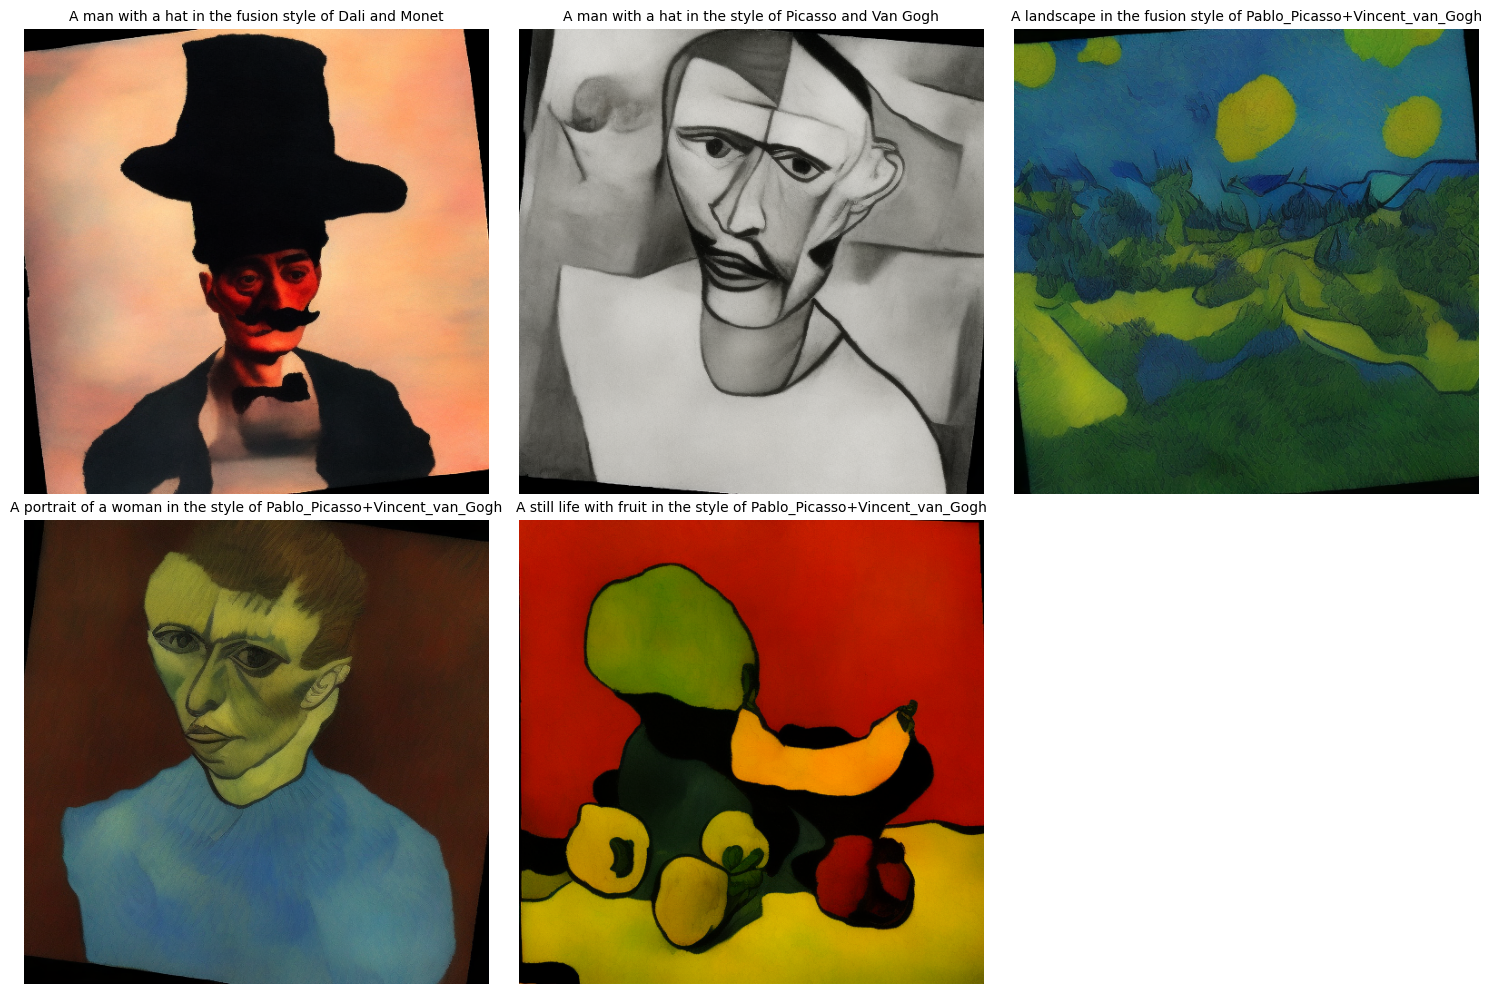

In [6]:
plt.figure(figsize=(15, 10))
for i, (prompt, image) in enumerate(generated_images.items()):
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(prompt, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Step 7: Evaluate Results
Evaluate the generated images using CLIP scores, comparing base and fused models.

In [7]:
evaluate_pipeline(adapter_paths, weights, base_model, prompts)

2025-07-27 20:25:48,737 - src.model_runner - INFO - Evaluating fusion: Pablo_Picasso+Vincent_van_Gogh
2025-07-27 20:25:48,739 - utils.helper - INFO - Using device: mps
Loading pipeline components...: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
2025-07-27 20:26:29,321 - utils.helper - INFO - Loaded pipeline from stabilityai/sd-turbo
Generating w

## Conclusion
This notebook demonstrated the full pipeline:
- Loaded dataset from `data/processed/`.
- Trained LoRA adapters (if needed) with sampled data and saved to `outputs/lora_weights/`.
- Generated 5 images with fused styles, saved to `outputs/images/fusion_outputs/{fusion_name}`.
- Evaluated images using CLIP scores.

To try different artists, update `adapter_paths` and `weights` in `configs/model_config.yaml`. For more prompts, modify the `prompts` list above.